# Projet M1 

#### Initialisation et dépendances 
Charge les bibliothèques nécessaires.

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function (lines) { return false ; }

<IPython.core.display.Javascript object>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as sw
import math
from scipy import signal
from scipy.signal import butter, lfilter

# Fichier audio

Cette section contient l'étude du fichier audio chargé. Vous pourrez y trouver son spectre d'amplitude ainsi que son spectrogramme.

Vous pouvez configurer la source du fichier audio dans la cellule ci-dessous.

In [7]:
# Source
file = "src/test2.wav"

#### Spectre d'amplitude

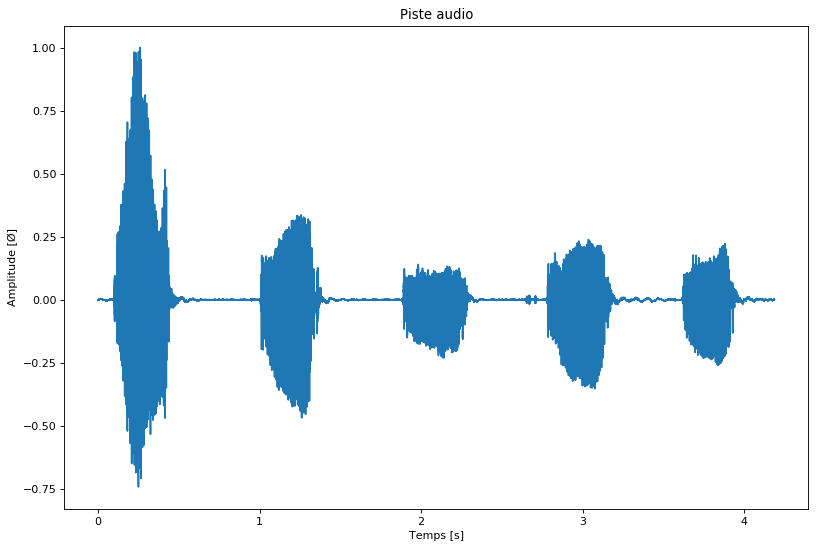

In [8]:
# Lecture du fichier audio
fs, y = sw.read(file)
# y = np.array(y, dtype=float)
yn = y/max(y)

# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

# Affichage du spectre d'amplitude
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Piste audio')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude [Ø]')
plt.plot(t, yn)
plt.show()

#### Spectrogramme

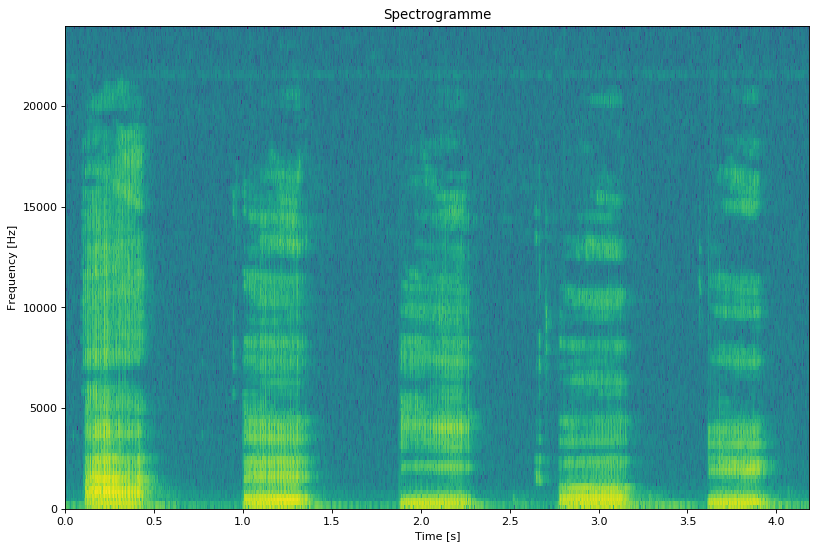

In [9]:
# Affichage du spectrogramme
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Spectrogramme')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.specgram(y, Fs=fs)
plt.show()


# Banque de filtres

In [10]:
# Ordre des filtres
n = 3
# Facteur de qualité
q = 3
# Nombre de filtres
nb_filters = 16
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000

#### Passe-bande (butterworth)
La fonction ci-dessous permet de générer un filtre passe-bande analogique.
* fc : Fréquence centrale
* q : Facteur de qualité
* n : Ordre du filtre

In [11]:
def bandpass(fc, q, n, fs):
    # Calcul de la bande passante grâce au facteur de qualité
    df = fc / q
    # Calcul de la fréquence de Nyquist
    nyq = fs / 2
    # Détermination des fréquences de coupures basses et hautes
    fl = (fc - df/2) / nyq
    fh = (fc + df/2) / nyq
    # Debug
    print("Fc : ", fc)
    # Création du filtre de butterworth    
    return butter(N=n, Wn=[fl, fh], btype='band')

#### Génération de la banque de filtres

In [51]:
# Banque des filtres
filters = []
filters_fc = []
# Calcul du pas
step = round((fmax-fmin)/nb_filters)
# Génération des filtres
for fc in range(fmin, fmax, step):
    filters_fc.append(fc)
    filters.append(bandpass(fc, q, n, fs))

Fc :  300
Fc :  469
Fc :  638
Fc :  807
Fc :  976
Fc :  1145
Fc :  1314
Fc :  1483
Fc :  1652
Fc :  1821
Fc :  1990
Fc :  2159
Fc :  2328
Fc :  2497
Fc :  2666
Fc :  2835


#### Réponse fréquentielle de la banque de filtres

C:\ProgramUser\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


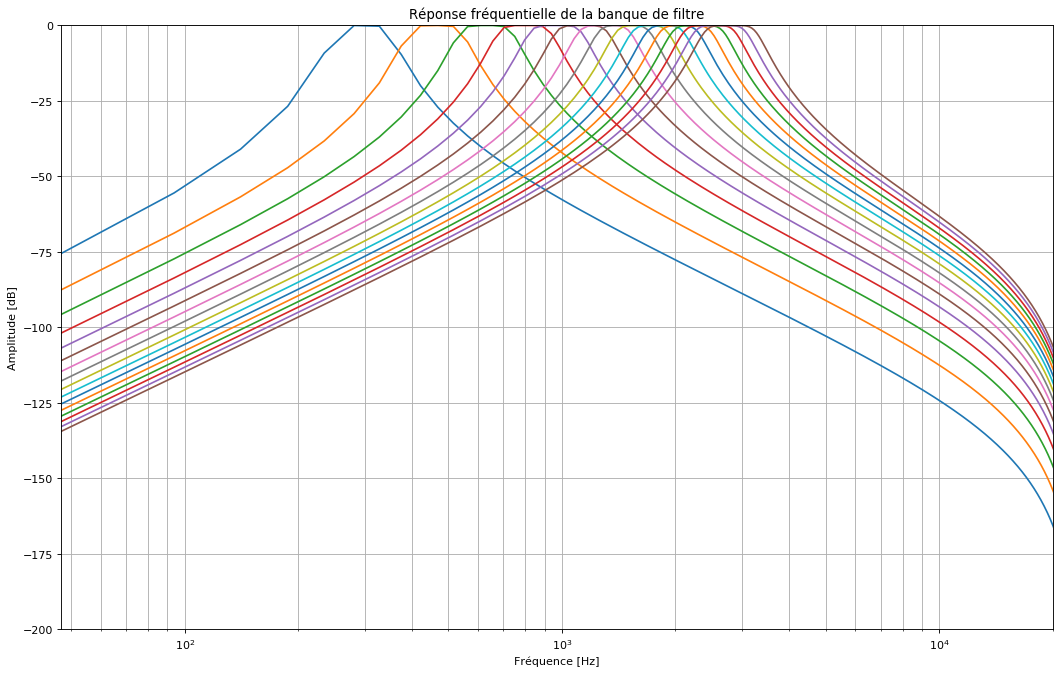

In [13]:
# Préparation de l'affichage
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

# Affichage des filtres
for i in range(len(filters)):
    # Calcul de la réponse fréquentielle du filtre
    b, a = filters[i]
    w, h = signal.freqz(b, a)
    # Affichage
    plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

# Données d'affichage
plt.title("Réponse fréquentielle de la banque de filtre")
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0, 20000)
plt.ylim(-200, 0)
plt.grid(which='both', axis='both')
plt.show()

#### Application de la banque de filtres

In [72]:
# Signaux filtrés
filtered = []
filtered.append(y)
t = np.linspace(0, N/fs, N)
# Application de la banque de filtres
for i in range(len(filters)):
    # Calcul de la réponse
    b, a = filters[i]
    filtered.append(lfilter(b, a, y))

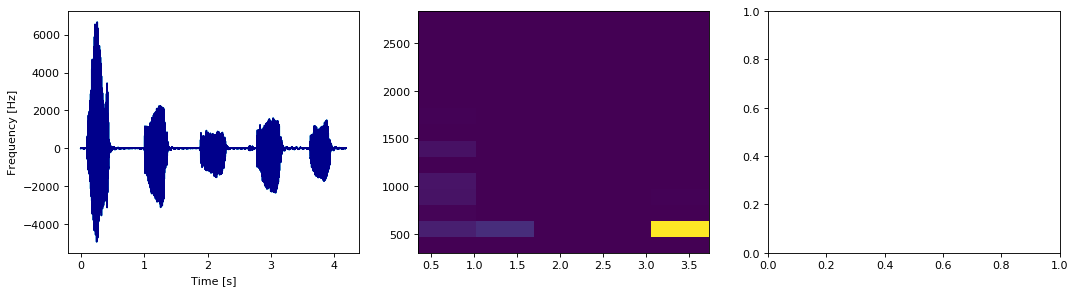

In [79]:
# Affichage des signaux filtrés
for i in range(len(filtered)):
    # Préparation des figures
    f, ax = plt.subplots(1, 3, figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
    # Affichage du spectre d'amplitude
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_xlabel('Time [s]')
    ax[0].plot(t, y, color='aqua')
    ax[0].plot(t, filtered[i], color='darkblue')
    # Affiachage du spectrogramme
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [s]')
    spectrum, freqs, time, img = ax[1].specgram(filtered[i], Fs=fs, NFFT=2**int(math.log(fs, 2)))
    ax[1].cla()
    
    #
    rspectrum = []; rfreqs = []; rtime = time
    for j in range(len(filters_fc)):
        fc_index = np.argmin(np.abs(freqs - filters_fc[j]))
        rspectrum.append(spectrum[fc_index])
        rfreqs.append(freqs[fc_index])
        
    ax[1].pcolormesh(rtime, rfreqs, rspectrum)
    #ax[1].plot()
    
    
    # Affichage de l'energie
    #ax[2].set_ylabel('Frequency [Hz]')
    #ax[2].set_xlabel('Time [s]')
    #ax[2].set_ylim([0, 2500])
    #ax[2].plot(time, np.sum(spectrum, axis=0))
    
    
    
    
    # Affichage
    plt.show()
    break
        
